# 악성사이트 탐지 머신러닝 모델 개발 (3)

### 목표
 * 웹 페이지에서 Feature 크롤링 연습
 * AI모델을 통해 악성사이트 여부를 판별

### 데이터
* train_0307.csv

---

In [61]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

import matplotlib.pyplot as plt

In [2]:
x_train = pd.read_csv('data/x_train.csv')
y_train = pd.read_csv('data/y_train.csv')
x_test = pd.read_csv('data/x_test.csv')
y_test = pd.read_csv('data/y_test.csv')

## 7> 데이터 모델링

In [3]:
display(x_test.head(2))
display(y_test.head(2))

,url_len,url_num_hyphens_dom,url_path_len,url_domain_len,url_hostname_len,url_num_dots,url_num_underscores,url_query_len,url_num_query_para,url_ip_present,...,url_port,html_num_tags('iframe'),html_num_tags('script'),html_num_tags('embed'),html_num_tags('object'),html_num_tags('div'),html_num_tags('head'),html_num_tags('body'),html_num_tags('form'),html_num_tags('a')
0,21.0,0.0,0.0,21.0,21.0,2.0,0.0,0.0,0.0,0,...,0,1.0,12.0,0.0,0.0,214.0,2.0,1.0,1.0,207.0
1,120.0,0.0,85.0,35.0,35.0,6.0,0.0,0.0,0.0,0,...,0,0.0,6.0,0.0,0.0,11.0,1.0,1.0,2.0,35.0


,label
0,0
1,1


In [3]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2261, 20), (2261, 1), (970, 20), (970, 1))

In [4]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()

####  7-0> Confusion Matrix 함수 정의

* Confusion Matrix : 학습을 통한 예측 성능을 측정하기 위해 예측 value와 실제 value를 비교하는 표
* confusion matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

    - confusion = confusion_matrix(test_y, dt_pred)
    - fig, ax = plt.subplots(figsize=(10,3))
    - plot_confusion_matrix(ax, confusion, fontsize=30)

In [9]:
def plot_confusion_matrix(ax, matrix, labels = ['malicious', 'benign'], title='Confusion matrix', fontsize=9):
    ax.set_xticks([x for x in range(len(labels))])
    ax.set_yticks([y for y in range(len(labels))])

    # Place labels on minor ticks
    ax.set_xticks([x + 0.5 for x in range(len(labels))], minor=True)
    ax.set_xticklabels(labels, rotation='vertical', fontsize=fontsize, minor=True)
    ax.set_yticks([y + 0.5 for y in range(len(labels))], minor=True)
    ax.set_yticklabels(labels[::-1], fontsize=fontsize, minor=True)

    # Hide major tick labels
    ax.tick_params(which='major', labelbottom='off', labelleft='off')

    # Finally, hide minor tick marks
    ax.tick_params(which='minor', width=0)

    # Plot heat map
    proportions = [1. * row / sum(row) for row in matrix]
    ax.pcolor(np.array(proportions[::-1]), cmap=plt.cm.Pastel2)

    # Plot counts as text
    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            confusion = matrix[::-1][row][col]
            if confusion != 0:
                ax.text(col + 0.5, row + 0.5, int(confusion),
                        fontsize=fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')

    # Add finishing touches
    ax.grid(True, linestyle=':')
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('prediction', fontsize=fontsize)
    ax.set_ylabel('actual', fontsize=fontsize)

    plt.show()

### 7-1> LogisticRegression


In [ ]:
from sklearn.preprocessing import StandardScaler

In [6]:
### lbfgs 등의 LR 내 최적화 알고리즘이 지정된 반복 횟수(max_iter) 내에서 수렴하지 못하는 경고가 발생하여 임시로 정규화
scaler = StandardScaler()
x_train_lr = scaler.fit_transform(x_train)
x_test_lr = scaler.transform(x_test)

In [7]:
param_lr = {'C': [0.01, 0.1, 1],
            # 'solver': ['saga', 'sag', 'liblinear', 'lbfgs'],
            'max_iter': [100, 200, 500]}

model_lr = GridSearchCV(LogisticRegression(),
                        param_grid=param_lr,
                        cv=5,
                        scoring='accuracy',
                        verbose=1)

model_lr.fit(x_train_lr, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'max_iter': [100, 200, 500]},
             scoring='accuracy', verbose=1)

In [13]:
model_lr.best_estimator_

LogisticRegression(C=1)

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       485
           1       0.86      0.85      0.86       485

    accuracy                           0.86       970
   macro avg       0.86      0.86      0.86       970
weighted avg       0.86      0.86      0.86       970



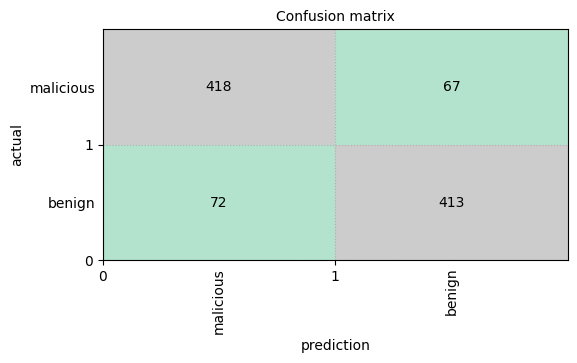

In [10]:
y_pred_lr = model_lr.predict(x_test_lr)

print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
fig, ax = plt.subplots(figsize=(6,3))
plot_confusion_matrix(ax, cm_lr, fontsize=10)

In [64]:
def f1_acc(test, pred):
    f1 = round(f1_score(test, pred), 4) * 100
    acc = round(accuracy_score(test, pred), 4) * 100
    
    return f1, acc

In [65]:
lr_f1, lr_acc = f1_acc(y_test, y_pred_lr)
lr_f1, lr_acc

(85.6, 85.67)

### 7-2> RandomForest

In [11]:
param_rf = {'max_depth': [3, 5, 7, 9, 11],
            'min_samples_split': [2, 5, 10]}

model_rf = GridSearchCV(RandomForestClassifier(random_state=7),
                        param_grid=param_rf,
                        cv=5,
                        scoring='accuracy',
                        verbose=1)

model_rf.fit(x_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=7),
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=1)

In [12]:
model_rf.best_estimator_

RandomForestClassifier(max_depth=11, min_samples_split=5, random_state=7)

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       485
           1       0.93      0.94      0.94       485

    accuracy                           0.94       970
   macro avg       0.94      0.94      0.94       970
weighted avg       0.94      0.94      0.94       970



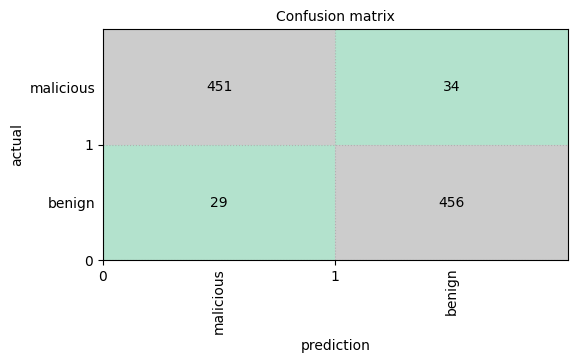

In [14]:
y_pred_rf = model_rf.predict(x_test)

print(classification_report(y_test, y_pred_rf))

cm_lr = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(6,3))
plot_confusion_matrix(ax, cm_lr, fontsize=10)

In [66]:
rf_f1, rf_acc = f1_acc(y_test, y_pred_rf)
rf_f1, rf_acc

(93.54, 93.51)

### 7-3> Tensorflow Keras

In [ ]:
from keras.callbacks import EarlyStopping

In [24]:
x_train.shape, y_train.shape

((2261, 20), (2261,))

* One-Hot 인코딩 pass
* y값이 0또는 1이므로 output_layer의 유닛수를 1로 하면 똑같음. (원-핫 적용하면 2로)

In [16]:
# from keras.utils import to_categorical

# # len_y = len(set(np.unique(y_train)))
# len_y = y_train.nunique() # Series.nunique

# y_train_tf = to_categorical(y_train, len_y)
# y_test_tf = to_categorical(y_test, len_y)
# y_train_tf.shape, y_test_tf.shape

((2261, 2), (970, 2))

In [25]:
# python 3.9.6 에서는 아래 코드를 안쓰면 warning, but summary 형태 다름
# tf.compat.v1.reset_default_graph()
# python 3.10.13 에서는 warning 없음
keras.backend.clear_session()

il = keras.layers.Input(shape=(20,))
hl1 = keras.layers.Dense(256, activation='relu')(il) # 20*256 + 256 (il*hl1 + hl1)
hl2 = keras.layers.Dense(256, activation='relu')(hl1) # 256*256 + 256 (hl1*hl2 + hl2)
hl3 = keras.layers.Dense(64, activation='relu')(hl2) # 256*64 + 64 (hl2*hl3 + hl3)
ol = keras.layers.Dense(1, activation='sigmoid')(hl3) # 64*1 + 1 (hl3*ol + ol)

model_tf = keras.models.Model(il, ol)

model_tf.compile(loss=keras.losses.binary_crossentropy,
                 metrics=['accuracy'],
                 optimizer='adam')

model_tf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 256)               5376      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 87,681
Trainable params: 87,681
Non-trainable params: 0
_________________________________________________________________


In [29]:
y_test[:5], y_train[:5]

(0    1
 1    1
 2    1
 3    1
 4    1
 Name: label, dtype: int64,
 0    1
 1    0
 2    1
 3    1
 4    1
 Name: label, dtype: int64)

* 61 : mini-batch 수
    - 전체 데이터(2261)를 61묶음으로 나누어서 1epoch마다 가중치 업데이트
    - batch-size=32 default
    - 1/61: 0~31, ... 61/61: 2201~2261
* 50 : epoch 수
    - 현재 학습 데이터를 한 번씩 학습시킬 횟수

In [27]:
es = EarlyStopping(monitor='val_loss',  # 이전 학습 상황과 비교하여 개선 여부를 판단할 지표, fit에서 validation_split(검증 데이터 분할)을 지정해야함
                   min_delta=0,         # '의미 있는 변화'로 간주할 최소 값, 0이면 지표가 조금이라도 개선되면 계속 훈련
                   patience=5,         # 횟수만큼 지표가 개선되지 않아도 훈련을 중단하지 않고 계속
                   verbose=1,
                   restore_best_weights=True) # 훈련 중 가장 성능이 좋았던 가중치 복원

In [31]:
model_tf.fit(x_train, y_train,
             validation_split=0.15,
             callbacks=[es],
             epochs=50,
             verbose=1,
             shuffle=True)

Epoch 1/50
61/61 [==============================] - 0s 3ms/step - loss: 0.1585 - accuracy: 0.9381 - val_loss: 0.2453 - val_accuracy: 0.9088
Epoch 2/50
61/61 [==============================] - 0s 1ms/step - loss: 0.3621 - accuracy: 0.8917 - val_loss: 0.2243 - val_accuracy: 0.8971
Epoch 3/50
61/61 [==============================] - 0s 1ms/step - loss: 0.2595 - accuracy: 0.9151 - val_loss: 0.2268 - val_accuracy: 0.9088
Epoch 4/50
61/61 [==============================] - 0s 1ms/step - loss: 0.1792 - accuracy: 0.9328 - val_loss: 0.1935 - val_accuracy: 0.9324
Epoch 5/50
61/61 [==============================] - 0s 1ms/step - loss: 0.1652 - accuracy: 0.9370 - val_loss: 0.1790 - val_accuracy: 0.9353
Epoch 6/50
61/61 [==============================] - 0s 1ms/step - loss: 0.1485 - accuracy: 0.9417 - val_loss: 0.1653 - val_accuracy: 0.9382
Epoch 7/50
61/61 [==============================] - 0s 2ms/step - loss: 0.1389 - accuracy: 0.9474 - val_loss: 0.1613 - val_accuracy: 0.9265
Epoch 8/50
61/61 [==

In [32]:
y_pred_tf = model_tf.predict(x_test)
y_pred_tf.shape, y_pred_tf[:5]

31/31 [==============================] - 0s 441us/step


((970, 1),
 array([[0.9967904 ],
        [0.95986056],
        [1.        ],
        [0.9929933 ],
        [0.9901587 ]], dtype=float32))

In [43]:
y_pred_tf2 = np.round(y_pred_tf, 0).reshape(-1)
y_test.shape, y_pred_tf2.shape

((970,), (970,))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       485
           1       0.94      0.90      0.92       485

    accuracy                           0.92       970
   macro avg       0.92      0.92      0.92       970
weighted avg       0.92      0.92      0.92       970



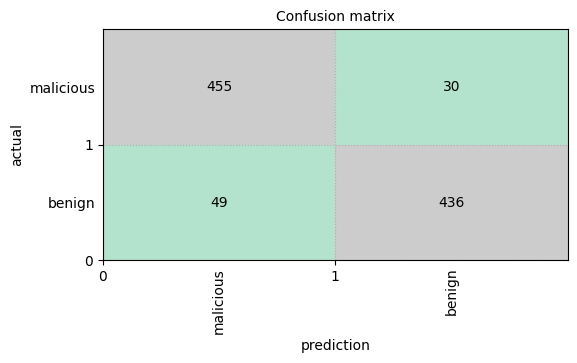

In [44]:
print(classification_report(y_test, y_pred_tf2))

cm_tf = confusion_matrix(y_test, y_pred_tf2)
fig, ax = plt.subplots(figsize=(6,3))
plot_confusion_matrix(ax, cm_tf, fontsize=10)

In [67]:
tf_f1, tf_acc = f1_acc(y_test, y_pred_tf2)
tf_f1, tf_acc

(91.69, 91.86)

### 7-4> 스케일링 진행 후 다시 학습
* f1-score 와 accuracy_score 가 0.94로 가장 높았던 **RandomForest** 모델 선택

In [57]:
model_rf.best_estimator_

RandomForestClassifier(max_depth=11, min_samples_split=5, random_state=7)

In [75]:
zscore_cols = ['url_hostname_len', 'url_entropy']
log_cols = list(set(x_train.select_dtypes(include=['float64']).columns) - set(zscore_cols))
cat_cols = x_train.select_dtypes(include=['int']).columns

print("전체 컬럼수 : %d\n정규분포와 비슷한 컬럼수 : %d\n범주형 컬럼수 : %d\n이상치 많은 컬럼수 : %d"
       % (len(x_train.columns), len(zscore_cols),
      len(cat_cols), len(log_cols)))

전체 컬럼수 : 20
정규분포와 비슷한 컬럼수 : 2
범주형 컬럼수 : 4
이상치 많은 컬럼수 : 14


In [76]:
display(x_train[zscore_cols].head(2))
display(x_train[log_cols].head(2))
display(x_train[cat_cols].head(2))

,url_hostname_len,url_entropy
0,17.0,5.025647
1,17.0,4.053509


,html_num_tags('embed'),html_num_tags('object'),url_len,html_num_tags('script'),html_num_tags('div'),html_num_tags('iframe'),html_num_tags('a'),url_num_query_para,html_num_tags('head'),url_num_underscores,html_num_tags('body'),html_num_tags('form'),url_num_dots,url_num_hyphens_dom
0,0.0,0.0,126.0,14.0,46.0,0.0,0.0,2.0,1.0,5.0,1.0,1.0,2.0,0.0
1,0.0,0.0,17.0,14.0,74.0,2.0,132.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0


,url_ip_present,url_chinese_present,url_port,is_url_length_over
0,0,0,0,1
1,0,0,0,0


In [ ]:
scaler = StandardScaler()
x_train_z = pd.DataFrame(scaler.fit_transform(x_train[zscore_cols]), columns=zscore_cols)
x_test_z = pd.DataFrame(scaler.transform(x_test[zscore_cols]), columns=zscore_cols)

x_train_l = np.log1p(x_train[log_cols])
x_test_l = np.log1p(x_test[log_cols])

x_train_s = pd.concat([x_train_z, x_train_l, x_train[cat_cols]], axis=1)
x_test_s = pd.concat([x_test_z, x_test_l, x_test[cat_cols]], axis=1)

display(x_train_s.head(2))
display(x_test_s.head(2))

,url_hostname_len,url_entropy,html_num_tags('embed'),html_num_tags('object'),url_len,html_num_tags('script'),html_num_tags('div'),html_num_tags('iframe'),html_num_tags('a'),url_num_query_para,html_num_tags('head'),url_num_underscores,html_num_tags('body'),html_num_tags('form'),url_num_dots,url_num_hyphens_dom,url_ip_present,url_chinese_present,url_port,is_url_length_over
0,-0.331079,1.930663,0.0,0.0,4.844187,2.70805,3.850148,0.000000,0.000000,1.098612,0.693147,1.791759,0.693147,0.693147,1.098612,0.0,0,0,0,1
1,-0.331079,-0.468622,0.0,0.0,2.890372,2.70805,4.317488,1.098612,4.890349,0.000000,0.693147,0.000000,0.693147,0.693147,1.098612,0.0,0,0,0,0


,url_hostname_len,url_entropy,html_num_tags('embed'),html_num_tags('object'),url_len,html_num_tags('script'),html_num_tags('div'),html_num_tags('iframe'),html_num_tags('a'),url_num_query_para,html_num_tags('head'),url_num_underscores,html_num_tags('body'),html_num_tags('form'),url_num_dots,url_num_hyphens_dom,url_ip_present,url_chinese_present,url_port,is_url_length_over
0,0.369548,-0.173737,0.0,0.0,3.465736,1.098612,3.737670,0.0,2.833213,0.0,0.693147,0.0,0.693147,0.693147,0.693147,0.0,0,0,0,0
1,-0.831527,0.223403,0.0,0.0,3.784190,1.609438,3.583519,0.0,2.079442,0.0,0.693147,0.0,0.693147,0.693147,1.386294,0.0,0,0,0,0


In [80]:
model_lr.fit(x_train_s, y_train)
y_pred_s_lr = model_lr.predict(x_test_s)
lr_s_f1, lr_s_acc = f1_acc(y_test, y_pred_s_lr)
lr_s_f1, lr_s_acc

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\gabri\.conda\envs\ml_pipeline\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\gabri\.conda\envs\ml_pipeline\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

(86.29, 86.08)

In [81]:
model_rf.fit(x_train_s, y_train)
y_pred_s_rf = model_rf.predict(x_test_s)
rf_s_f1, rf_s_acc = f1_acc(y_test, y_pred_s_rf)
rf_s_f1, rf_s_acc

Fitting 5 folds for each of 15 candidates, totalling 75 fits


(93.63, 93.61)

In [71]:
x_train.shape, x_train_s.shape

((2261, 20), (2261, 16))

In [82]:
model_tf.fit(x_train_s, y_train,
             validation_split=0.15,
             callbacks=[es],
             epochs=50,
             verbose=1,
             shuffle=True)

y_pred_s_tf = model_tf.predict(x_test_s)
y_pred_s_tf2 = np.round(y_pred_s_tf, 0).reshape(-1)
tf_s_f1, tf_s_acc = f1_acc(y_test, y_pred_s_tf2)
tf_s_f1, tf_s_acc

Epoch 1/50
61/61 [==============================] - 0s 2ms/step - loss: 0.7196 - accuracy: 0.6845 - val_loss: 0.3944 - val_accuracy: 0.8324
Epoch 2/50
61/61 [==============================] - 0s 1ms/step - loss: 0.3767 - accuracy: 0.8334 - val_loss: 0.3783 - val_accuracy: 0.8176
Epoch 3/50
61/61 [==============================] - 0s 1ms/step - loss: 0.3700 - accuracy: 0.8365 - val_loss: 0.2748 - val_accuracy: 0.8882
Epoch 4/50
61/61 [==============================] - 0s 1ms/step - loss: 0.2967 - accuracy: 0.8829 - val_loss: 0.2659 - val_accuracy: 0.8882
Epoch 5/50
61/61 [==============================] - 0s 1ms/step - loss: 0.2776 - accuracy: 0.8855 - val_loss: 0.2564 - val_accuracy: 0.8941
Epoch 6/50
61/61 [==============================] - 0s 1ms/step - loss: 0.2851 - accuracy: 0.8792 - val_loss: 0.2793 - val_accuracy: 0.8794
Epoch 7/50
61/61 [==============================] - 0s 1ms/step - loss: 0.2823 - accuracy: 0.8787 - val_loss: 0.2543 - val_accuracy: 0.8735
Epoch 8/50
61/61 [==

(92.34, 92.27)

## 8> 성능 비교
* 스케일링 전/후 3개의 모델 모두 성능이 향상되었다.

In [87]:
lr1 = pd.DataFrame({'f1': [lr_f1], 'acc': [lr_acc]}, index=['LogisticRegression'])
lr2 = pd.DataFrame({'f1': [lr_s_f1], 'acc': [lr_s_acc]}, index=['LogisticRegression_Scaled'])

rf1 = pd.DataFrame({'f1': [rf_f1], 'acc': [rf_acc]}, index=['RandomForest'])
rf2 = pd.DataFrame({'f1': [rf_s_f1], 'acc': [rf_s_acc]}, index=['RandomForest_Scaled'])

tf1 = pd.DataFrame({'f1': [tf_f1], 'acc': [tf_acc]}, index=['Tensorflow_ANN'])
tf2 = pd.DataFrame({'f1': [tf_s_f1], 'acc': [tf_s_acc]}, index=['Tensorflow_ANN_Scaled'])

performance = pd.concat([lr1, lr2, rf1, rf2, tf1, tf2], axis=0)
performance

,f1,acc
LogisticRegression,85.60,85.67
LogisticRegression_Scaled,86.29,86.08
RandomForest,93.54,93.51
RandomForest_Scaled,93.63,93.61
Tensorflow_ANN,91.69,91.86
Tensorflow_ANN_Scaled,92.34,92.27
